## Reading in a large netCDF array, converting to Zarr, and rechunking for the purpose of calculating quantiles along a single dimension

Load in a bunch of modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys
sys.path.append('/home/bwallace/scripts/functions/')
import main as pwrf
import xarray as xr
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from netCDF4 import Dataset
from datetime import datetime, timedelta, date
import matplotlib.dates as mdates
import os

### Call in your Dask distributed client

We'll also specify the specific path we want for our dashboard so we can monitor the job progress.

In [2]:
import dask
from distributed import Client

dask.config.set({'distributed.dashboard.link':'https://jupyter.alcf.anl.gov/theta/user/{USER}/proxy/{port}/status'})

client = Client()

You can view the dashboard by printing out the client object and clicking on the corresponding link

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyter.alcf.anl.gov/theta/user/bwallace/proxy/8787/status,
Dashboard: https://jupyter.alcf.anl.gov/theta/user/bwallace/proxy/8787/status,Workers: 8
Total threads: 64,Total memory: 503.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39860,Workers: 8
Dashboard: https://jupyter.alcf.anl.gov/theta/user/bwallace/proxy/8787/status,Total threads: 64
Started: Just now,Total memory: 503.60 GiB
Comm: tcp://127.0.0.1:38253,Total threads: 8
Dashboard: https://jupyter.alcf.anl.gov/theta/user/bwallace/proxy/38895/status,Memory: 62.95 GiB
Nanny: tcp://127.0.0.1:38063,


The next three cells gather all your paths together. This could be done a lot easier with glob.glob, but sometimes specifically picking out dates gives you more control

In [4]:
###THIS NEEDS TO BE CHANGED WHEN CHANGING SCENARIO

dates_daily=[]
dates_daily.append(\
    [\
    entry for entry in np.arange(datetime(2085,10,1),datetime(2100,10,1),timedelta(days=1)).astype(datetime)\
    ]\
                 )
dates_daily=np.array(dates_daily).flatten()

In [5]:
scenario='end_of_century_8p5' #historical or end_of_century_8p5 - DONT FORGET TO CHANGE DATES ABOVE!!!

path_to_files='/eagle/climate_severe/bwallace_scratch/hourly_resampled/'+scenario+'/'

In [6]:
paths=[]
for sd in dates_daily:
    sdyr,sdmo,sddy=str(sd.year),str(sd.month).zfill(2),str(sd.day).zfill(2)
    
    possible_path=path_to_files+'AFWA_TOTPRECIP_'+sdyr+sdmo+sddy+'.nc'
    if os.path.exists(possible_path):
        paths.append(possible_path)

Next we'll call in our data array using open_mfdataset(). I typically have more success using combine='nested' and specifying the concat_dim I'd like xarray to concatenate along. In this case, it's Time.

In [7]:
mfds=xr.open_mfdataset(paths,combine='nested',concat_dim='Time')

In [8]:
mfds.AFWA_TOTPRECIP.encoding={}

In [9]:
mfds

<xarray.Dataset>
Dimensions:         (Time: 131040, south_north: 899, west_east: 1399)
Coordinates:
  * Time            (Time) datetime64[ns] 2085-10-01 ... 2100-09-29T23:00:00
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (Time, south_north, west_east) float32 dask.array<chunksize=(24, 899, 1399), meta=np.ndarray>

#### When we print out our mfdataset, we can get some info about how the data is chunked based off the netCDF array. We can see that our field of interest, AFWA_TOTPRECIP, is chunked on the same interval as the data is stored, with 24 chunks in the Time dimension corresponding to the 24 hourly accumulated rainfall readings, and no chunks in the spatial dimensions.

These chunks would be particularly well suited to performing some operation along the spatial dimension for all times. For example, taking the mean of the spatial dimensions across all times and producing a time series.

In our use case, we want to calculate the quantile along the time dimension, which needs to consider all possible values along the time dimension. Having frequent chunks in time and no chunks in space is not optimal for addressing this problem. 

We could rechunk our mfdataset array during the open_mfdataset() call, but the behavior of specifying chunks within is limited to chunking WITHIN each input file. This means you can only specify a maximum chunk of 24 along the time dimension.

We could chunk after the fact, but this is not recommended, and for large file sizes with a lot of chunks, it takes A LOT of memory (more than your dataset) and produces a lot of tasks in the task graph.

So our solution is to utilize Zarr and Rechunker. Zarr is a highly compressible data storage format built around chunking and it's compatible with xarray in the same way that netCDF is. We can write our array as a Zarr file, and then rearrange its chunks using Rechunker.

To write a zarr array, we can just use .to_zarr(path_to_file).

In [10]:
mfds.to_zarr('/eagle/climate_severe/bwallace_scratch/ZARR/eoc8p5_AFWA_TOTPRECIP.zarr')

If you have your dask dashboard open, you'll notice that doing this is efficient and uses relatively little memory.

We can read in this created zarr file by importing the zarr module.

In [11]:
import zarr

Next we'll use zarr.open() and print out some information on the file.

In [12]:
source_group=zarr.open('/eagle/climate_severe/bwallace_scratch/ZARR/eoc8p5_AFWA_TOTPRECIP.zarr')
print(source_group.tree())

/
 ├── AFWA_TOTPRECIP (131040, 899, 1399) float32
 └── Time (131040,) int64


We can see that the total size of the zarr array is identical to the size of our netCDF array and that it also contains information for the Time dimension.

The chunks in this Zarr array are also kept identical to how the chunks were oriented in the original netCDF array.

To rechunk, we can import rechunker

In [13]:
from rechunker import rechunk

Using rechunker, we can specify our target chunks and the file will be rewritten with the new chunk structure.

These new chunks are a little bigger but have a different orientation, and are now oriented for efficient analysis across the time dimension. 

We also want to specify the location of our target file and our intermediate temporary file. We need to do this because of the way rechunker works. I find that it's easier to understand how this operation works based on the image below.

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*skmMOIOawvuBNH29ECgcqg.png" alt="Alternative text" />


In [14]:
target_chunks={
    'AFWA_TOTPRECIP':{'Time':131040,'south_north':40,'west_east':40},
    'Time': None,
}

target_store='/eagle/climate_severe/bwallace_scratch/ZARR/eoc8p5_AFWA_TOTPRECIP_rechunked.zarr'
temp_store='/eagle/climate_severe/bwallace_scratch/ZARR/eoc8p5_AFWA_TOTPRECIP_rechunked-tmp.zarr'

We also want to specify our max memory. From my experience, this can't be smaller than the size of an individual chunk. I haven't played around with this too much, but I think a higher value allows the operation to move faster at the cost of more memory. For now, I'm specifying a max_mem that's slightly bigger than 1 chunk.

In [15]:
max_mem='850MB'

Next, we create our rechunk plan, specifying the source array, the target chunks we'd like our new array to have, the max memory, where our new rechunked array will be stored, and where intermediate temporary data is stored.

In [16]:
array_plan=rechunk(source_group,target_chunks,max_mem,target_store,temp_store=temp_store)

Finally, to initiate our job, we'll use .execute() on our array plan.

In [ ]:
array_plan.execute()

/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/distributed/worker.py:2988: UserWarning: Large object of size 43.61 MiB detected in task graph: 
  ("('copy_read_to_intermediate-1b215299a2c501a9828f ... 48c', 219721)")
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


From my experience, rechunking our 650 GB rainfall array to be continuous in time and chunked in space took about 12 or so hours to complete.

We can open this newly completed rechunked Zarr array using xarray's open_zarr() function and print out some information about it.

In [2]:
xrds=xr.open_zarr('/eagle/climate_severe/bwallace_scratch/ZARR/eoc8p5_AFWA_TOTPRECIP_rechunked.zarr')

/tmp/ipykernel_2257/2410216854.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  xrds=xr.open_zarr('/eagle/climate_severe/bwallace_scratch/ZARR/eoc8p5_AFWA_TOTPRECIP_rechunked.zarr')


In [3]:
xrds

<xarray.Dataset>
Dimensions:         (Time: 131040, south_north: 899, west_east: 1399)
Coordinates:
  * Time            (Time) datetime64[ns] 2085-10-01 ... 2100-09-29T23:00:00
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (Time, south_north, west_east) float32 dask.array<chunksize=(131040, 40, 40), meta=np.ndarray>

We can see that this newly rechunked array is continuous in time and chunked in space, and that the size of an individual chunk is a fairly large 800 MiB. This new orientation is ideal for our analysis!

We'll calculate a quantile along the Time dimension and load it into memory for plotting.

In [ ]:
quantile=xrds.AFWA_TOTPRECIP.quantile(q=0.95,dim='Time').compute()

In [26]:
#quantile.to_netcdf('/eagle/climate_severe/bwallace_scratch/quantiles/AFWA_TOTPRECIP_q95_eoc8p5.nc')

We can plot the 95% quantile for hourly rainfall in the EoC8p5 runs and can see that the resulting values are fairly reasonable.

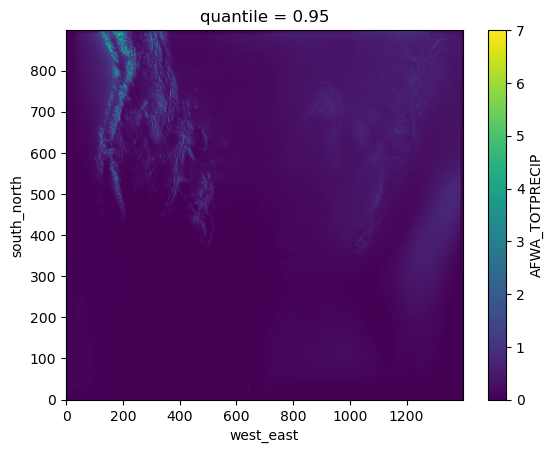

In [8]:
quantile.plot(vmin=0,vmax=7)

Lastly, we can do a quick confirmation that operations performed on this Zarr array are identical to operations performed on the netCDF array. Since all we're doing is rechunking the data to make it more compatible with distributed analysis, there's no approximation or modification done to the data itself.

We can do a quick and dirty comparison by calculating the 99% quantile for the first 24 hours between the unoptimally chunked netCDF array vs the optimally chunked Zarr array.

In [61]:
ncq=mfds.AFWA_TOTPRECIP[:24].quantile(q=0.99,dim='Time').compute()
zrq=xrds.AFWA_TOTPRECIP[:24].quantile(q=0.99,dim='Time').compute()

Differencing these two approximations and plotting the result shows that there is zero difference between the two fields!

This makes sense, as we are just rechunking the data.

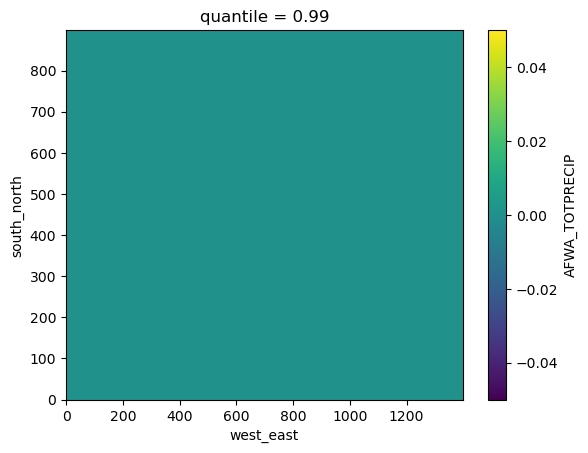

In [62]:
(ncq-zrq).plot()

On disk, Zarr takes up substantially less space than netCDF. For a 650 GB hourly rainfall array, the Zarr array on disk takes up about 95 GB. Through modules such as rechunker, the entire array can be effortlessly rechunked into different configurations for different analyses. It's also natively compatible with xarray and so can easily slot into a lot of pre-existing workflows!